C:\Users\snehi\AppData\Local\Temp\ipykernel_26240\2858254117.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





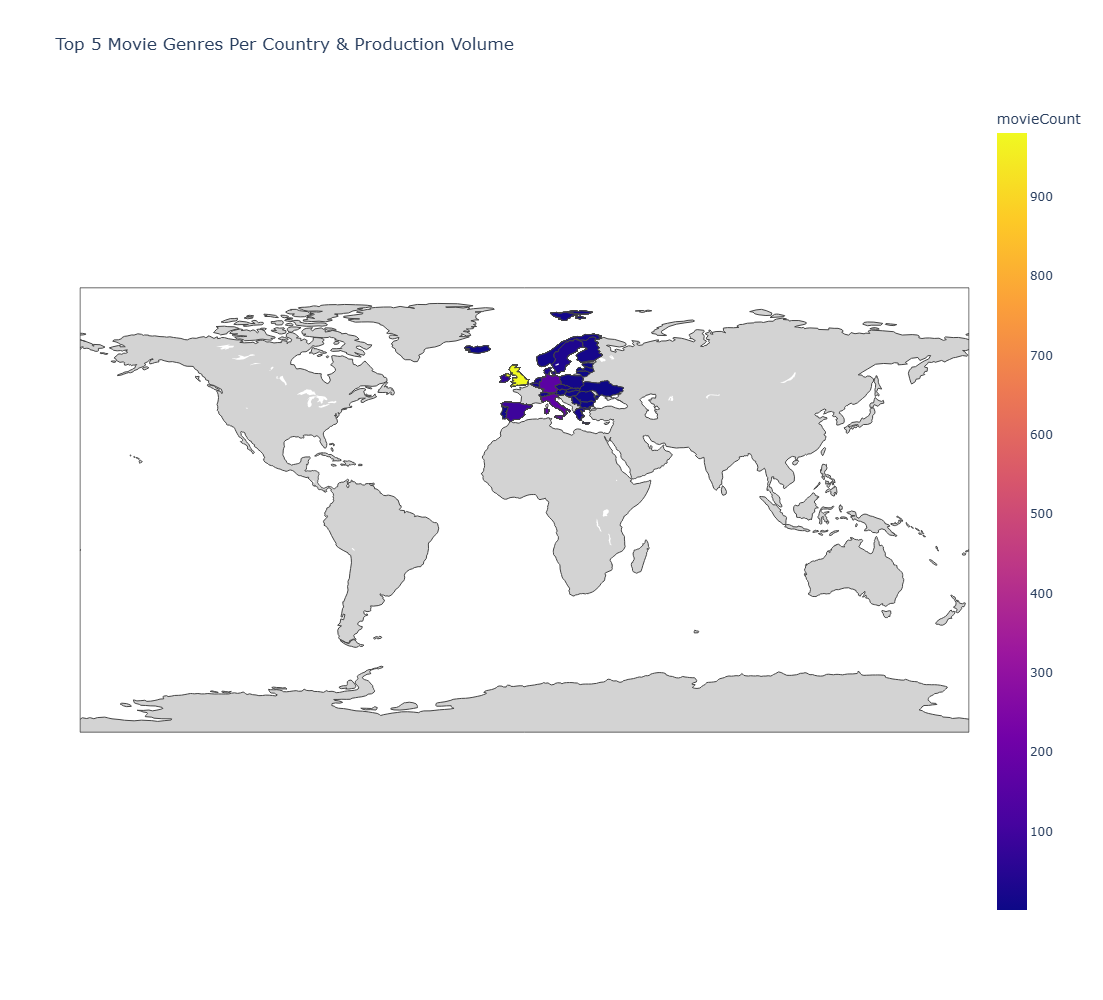

In [7]:
# Interpreting the World Map of Movie Genres & Production Volume
import plotly.express as px
import pandas as pd
import pycountry

# Load dataset
file_path = "European_data_2000.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Preprocess data
def preprocess_data(df, top_n=5):
    df["genres"] = df["genres"].astype(str).str.split(", ")  # Split genres
    exploded_df = df.explode("genres")  # Separate each genre
    
    country_genre_counts = exploded_df.groupby(["mainCountry", "genres"]).size().reset_index(name="count")
    top_genres = country_genre_counts.sort_values(["mainCountry", "count"], ascending=[True, False])
    top_genres = top_genres.groupby("mainCountry").head(top_n)
    
    # Map top genres per country
    top_genres_summary = top_genres.groupby("mainCountry")["genres"].apply(lambda x: ', '.join(map(str, x.unique()[:top_n]))).reset_index().rename(columns={"genres": "topGenres"})
    df = df.merge(top_genres_summary, on="mainCountry", how="left")
    df["topGenres"].fillna("No Data", inplace=True)
    
    # Manual corrections for misclassified regions
    country_corrections = {
        "French Guiana": "GUF",  # Corrected French Guiana
        "France": "FRA"
    }
    
    # Convert country names to ISO alpha-3 codes for mapping
    def get_country_code(name):
        if name in country_corrections:
            return country_corrections[name]
        try:
            return pycountry.countries.lookup(name).alpha_3
        except LookupError:
            return None  # Ignore unmatched countries
    
    df["iso_alpha"] = df["mainCountry"].apply(get_country_code)
    df.dropna(subset=["iso_alpha"], inplace=True)
    
    # Ensure French Guiana does not inherit France's data
    df = df[df["iso_alpha"] != "FRA"]
    df.loc[df["mainCountry"] == "French Guiana", "iso_alpha"] = "GUF"
    
    # Count movies per country
    country_movie_counts = df["mainCountry"].value_counts().to_dict()
    df["movieCount"] = df["mainCountry"].map(country_movie_counts)
    
    return df

df = preprocess_data(df)

# Create interactive world map
fig = px.choropleth(
    df, locations="iso_alpha", locationmode="ISO-3",
    color="movieCount", hover_name="mainCountry",
    hover_data={"topGenres": True, "movieCount": True, "iso_alpha": False},
    title="Top 5 Movie Genres Per Country & Production Volume",
    color_continuous_scale="plasma"
)

fig.update_layout(
    geo=dict(showcoastlines=True, showland=True, landcolor="lightgray"),
    width=1100, height=1000
)

fig.show()


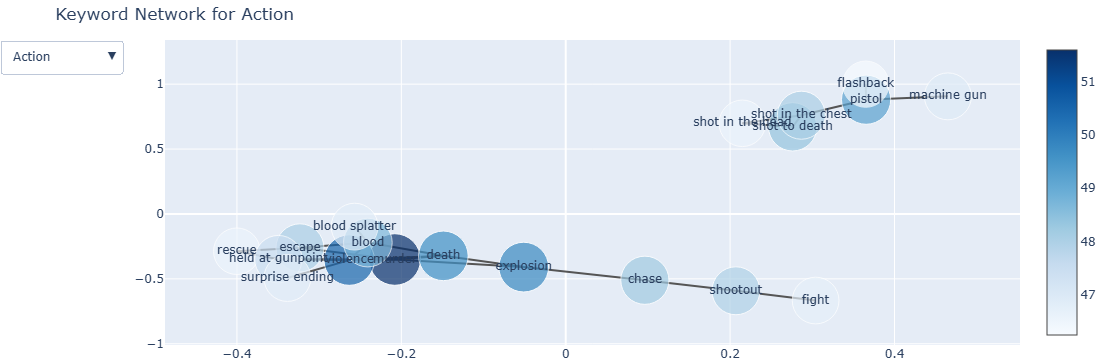

In [178]:
#An interactive network graph that shows the most frequently used keywords associated with different movie genres. You can select a genre
#from a dropdown menu. Nodes (circles): Each keyword is represented as a circle.
#Edges (lines): If two keywords frequently appear together in movies of that genre, they are connected with a line.
#Size of Nodes: Bigger circles mean the keyword appears more often in that genre.
#Color Gradient: Darker colors indicate more frequent keywords. You can hover over nodes to see specific keywords.
#Insights: Understanding what themes are common in different genres. Identifying audience expectations based on frequently used themes. 
#This can help in exploring how different genres are connected through storytelling elements.

import plotly.graph_objects as go
import networkx as nx
from collections import Counter
import plotly.express as px
import numpy as np
import pandas as pd
import re

# Load dataset
file_path = "European_data_2000.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Ensure 'genres' and 'keywords' are strings
df["genres"] = df["genres"].fillna("").astype(str)
df["keywords"] = df["keywords"].fillna("").astype(str)

# Get available genres
genres_list = sorted(set(
    [genre for sublist in df["genres"].str.split(", ").tolist() for genre in sublist]
))

# Generate network graphs for all genres
fig = go.Figure()
visibility_flags = []

# Function to generate cleaned and visually improved network graph
def generate_network_data(selected_genre):
    filtered_df_genre = df[df["genres"].str.contains(re.escape(selected_genre), na=False)]
    all_keywords = filtered_df_genre["keywords"].str.split(", ").explode()
    
    # Get most common keywords (Top 20 for better connections)
    keyword_counts = Counter(all_keywords)
    top_keywords = [k for k, v in keyword_counts.most_common(20)]
    all_keywords = [k for k in all_keywords if k in top_keywords]
    
    # Create network graph with increased connections
    G = nx.Graph()
    keyword_pairs = list(zip(all_keywords[:-1], all_keywords[1:]))
    
    # Keep more connections (Top 30 co-occurring pairs)
    pair_counts = Counter(keyword_pairs)
    top_pairs = [pair for pair, count in pair_counts.most_common(30)]
    
    for pair in top_pairs:
        G.add_edge(pair[0], pair[1], weight=pair_counts[pair])
    
    # Adjust node spacing (bring nodes closer)
    pos = nx.spring_layout(G, seed=42, k=0.3)
    nodes = list(G.nodes)
    
    # Scale node sizes logarithmically to balance common/rare keywords
    node_size = [np.log1p(keyword_counts[node]) * 10 for node in nodes]
    
    # Create Plotly traces
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y, line=dict(width=2, color="#555"), hoverinfo="none", mode="lines", visible=False
    )
    
    node_x, node_y, node_text = [], [], []
    for node in nodes:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
    
    node_trace = go.Scatter(
        x=node_x, y=node_y, mode="markers+text", hoverinfo="text",
        marker=dict(
            size=node_size, 
            color=node_size, 
            colorscale="blues",  # Color gradient for better visibility
            showscale=True
        ),
        text=node_text, visible=False
    )
    
    return edge_trace, node_trace

# Add traces for all genres
for genre in genres_list:
    edge_trace, node_trace = generate_network_data(genre)
    fig.add_trace(edge_trace)
    fig.add_trace(node_trace)
    visibility_flags.append(False)

# Set first genre as visible
fig.data[0].visible = True
fig.data[1].visible = True

# Create dropdown menu
dropdown_buttons = []
for i, genre in enumerate(genres_list):
    visibility = [False] * len(fig.data)
    visibility[i * 2] = True  # Edge trace
    visibility[i * 2 + 1] = True  # Node trace
    
    dropdown_buttons.append(
        dict(label=genre, method="update", args=[{"visible": visibility}, {"title": f"Keyword Network for {genre}"}])
    )

fig.update_layout(
    title=f"Keyword Network for {genres_list[0]}",
    showlegend=False,
    hovermode="closest",
    margin=dict(b=0, l=0, r=0, t=40),
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction="down",
            showactive=True
        )
    ]
)

fig.show()